# LIME - Local Interpretable Model-Agnostic Explanations

This assignment uses LIME, a package that provides "Locally Interpetable Model-agnostic Explanations" for machine learning models.

- **Locally interpretable**: for each specific prediction, we can provide a relevant explanation.
- **Model-agnostic**: we can provide the same sort of explanation for models of different classes.

For more documentation of the LIME package, see [here](https://github.com/marcotcr/lime) and [here](https://lime-ml.readthedocs.io/en/latest/index.html). The original paper describing the method is [here](https://arxiv.org/pdf/1602.04938.pdf).

Before we get started, answer the following questions:

1. Which of the three design choices determines whether an explanation describes local or global feature importance?



In [ ]:
!pip install lime # if you are running on JupyterLab, use !/opt/anaconda/bin/pip
!pip install xgboost

In [ ]:
%matplotlib inline

import sklearn.model_selection
import sklearn.metrics
import sklearn.datasets
import sklearn.ensemble
import sklearn.preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import warnings
import lime
import lime.lime_tabular
from lime import submodular_pick
import xgboost
from xgboost import plot_importance
import json
from collections import OrderedDict

import pandas as pd

np.random.seed(1)

***
## Part 1: Prepare the data

We will be using the Adult dataset which we can use to predict whether a person makes over 50K dollars per year based on census information. A version of the dataset is found on UCI ML Repository : [here](https://archive.ics.uci.edu/ml/datasets/adult).

### Read in the data

In [ ]:
# Read in the data
colnames = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num",
            "Marital-Status", "Occupation", "Relationship", "Race", "Sex",
            "Capital-Gain", "Capital-Loss","Hours-per-week", "Country",
            "income"]
data_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                      names = colnames)
print("Shape: ", data_df.shape)
data_df.head()

Shape:  (32561, 15)


Age          Workclass  fnlwgt   Education  Education-Num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        Marital-Status          Occupation    Relationship    Race      Sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   Capital-Gain  Capital-Loss  Hours-per-week         Country  income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

### Clean the data

In [ ]:
# TODO - Drop Education-Num, which has a functional dependency with Education
data_df = data_df.drop('Education-Num', axis=1)

In [ ]:
# Get a list of feature names (excluding the outcome variable)
feature_names = data_df.columns[:-1]

In [ ]:
# Mark labels and encode them using sklearn
labels = data_df.iloc[:,-1]
le= sklearn.preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
data = data_df.iloc[:,:-1]
le_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class names: ", class_names)
print("Label mapping: ", le_label_mapping)

Class names:  [' <=50K' ' >50K']
Label mapping:  {' <=50K': 0, ' >50K': 1}


In [ ]:
# Check if there are categorical variables that we need to make dummies for
print(data.dtypes)
# Get a list of which variables are categorical
categorical_features  = [i for i in range(len(data.dtypes)) if data.dtypes[i]=='object']
print("Indices of categorical features: ", categorical_features)

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Marital-Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital-Gain       int64
Capital-Loss       int64
Hours-per-week     int64
Country           object
dtype: object
Indices of categorical features:  [1, 3, 4, 5, 6, 7, 8, 12]


<ipython-input-52-20bc05c2a4ac>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_features  = [i for i in range(len(data.dtypes)) if data.dtypes[i]=='object']
<ipython-input-52-20bc05c2a4ac>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_features  = [i for i in range(len(data.dtypes)) if data.dtypes[i]=='object']
<ipython-input-52-20bc05c2a4ac>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_fea

LIME will require us to provde categorical variables as a single column, not as dummies, so we can't just explode these columns the way we normally would during pre-processing.

Instead, we'll use some sklearn tools to take the following steps:
1. Encode the existing categories with a number corresponding to each category
2. Make a dictionary storing the relationship between the original string category and the number we've replaced it with (categorical_names)
3. Make a function that we can use down the line to transform categorical variables into dummies

In [ ]:
categorical_names = {}
for feature in categorical_features:
    print("Feature: ", feature)
    # Use label encoder to map categories to numbers
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(data.iloc[:, feature])
    # Replace the categories with corresponding numbers in the original data
    data.iloc[:, feature] = le.transform(data.iloc[:, feature])
    # Store and print the mappings for reference later
    categorical_names[feature] = le.classes_
    print(categorical_names[feature])
    print("==================================================")

Feature:  1
[' ?' ' Federal-gov' ' Local-gov' ' Never-worked' ' Private'
 ' Self-emp-inc' ' Self-emp-not-inc' ' State-gov' ' Without-pay']
Feature:  3
[' 10th' ' 11th' ' 12th' ' 1st-4th' ' 5th-6th' ' 7th-8th' ' 9th'
 ' Assoc-acdm' ' Assoc-voc' ' Bachelors' ' Doctorate' ' HS-grad'
 ' Masters' ' Preschool' ' Prof-school' ' Some-college']
Feature:  4
[' Divorced' ' Married-AF-spouse' ' Married-civ-spouse'
 ' Married-spouse-absent' ' Never-married' ' Separated' ' Widowed']
Feature:  5
[' ?' ' Adm-clerical' ' Armed-Forces' ' Craft-repair' ' Exec-managerial'
 ' Farming-fishing' ' Handlers-cleaners' ' Machine-op-inspct'
 ' Other-service' ' Priv-house-serv' ' Prof-specialty' ' Protective-serv'
 ' Sales' ' Tech-support' ' Transport-moving']
Feature:  6
[' Husband' ' Not-in-family' ' Other-relative' ' Own-child' ' Unmarried'
 ' Wife']
Feature:  7
[' Amer-Indian-Eskimo' ' Asian-Pac-Islander' ' Black' ' Other' ' White']
Feature:  8
[' Female' ' Male']
Feature:  12
[' ?' ' Cambodia' ' Canada' ' Chi

In [ ]:
# This variable is where we store the original names of each category for each variable
categorical_names

{1: array([' ?', ' Federal-gov', ' Local-gov', ' Never-worked', ' Private',
        ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay'],
       dtype=object),
 3: array([' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th',
        ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate',
        ' HS-grad', ' Masters', ' Preschool', ' Prof-school',
        ' Some-college'], dtype=object),
 4: array([' Divorced', ' Married-AF-spouse', ' Married-civ-spouse',
        ' Married-spouse-absent', ' Never-married', ' Separated',
        ' Widowed'], dtype=object),
 5: array([' ?', ' Adm-clerical', ' Armed-Forces', ' Craft-repair',
        ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners',
        ' Machine-op-inspct', ' Other-service', ' Priv-house-serv',
        ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support',
        ' Transport-moving'], dtype=object),
 6: array([' Husband', ' Not-in-family', ' Other-relative', ' Own-child',
     

In [ ]:
# We can (and will) use this encoder function to transform the categorical columns into dummies--
# but we can't do that to the original dataset if we want to use LIME
encoder = ColumnTransformer(transformers=[('get_dummies', OneHotEncoder(), categorical_features)], remainder='passthrough')
encoder = encoder.fit(data)

### Split into training and test sets

We will us an 80/20 train-test split. We won't be doing any hyperparameter tuning during this lab, so no need to worry about a validation set.

In [ ]:
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(data, labels, train_size=0.80, random_state=10)
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)


Train shape:  (26048, 13)
Test shape:  (6513, 13)


***
## Part 2: Train a model

We will be using gradient boosted decision trees as implemented by the [xgboost](https://github.com/dmlc/xgboost) package.

In [ ]:
# Fit the model
gbtree = xgboost.XGBClassifier(n_estimators=200, max_depth=5)
gbtree.fit(encoder.transform(train), labels_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Make predictions
pred_labels_test = gbtree.predict(encoder.transform(test))

# Calculate accuracy on the test set
print("Test set accuracy: ", sklearn.metrics.accuracy_score(labels_test, pred_labels_test))

Test set accuracy:  0.866421004145555


***
## Part 3: Explaining predictions the usual way



### *TODO - Questions:**
*Hint:* If you don't know the answer, then Google is your best friend! I know folks will use AI tools like ChatGPT, but don't copy and paste answer directly. You can use these tools to search and teach yourself, but you should answer in your own words and understanding from your reserach.

1. How would you normally explain the predictions of a single decision tree?

A single decision tree makes predictions by following a hierarchical sequence of feature-based splits from the root node to a leaf node. To explain a prediction, one can trace the path through the tree used for that specific instance. Each split in the path corresponds to a rule (e.g., "Age ≤ 30" or "Education = Bachelor’s"), and the final leaf node provides the predicted class or value. This path acts as a transparent, human-readable explanation for why the model made a particular prediction.



2. What is a gradient boosted decision tree?

> Add blockquote

A gradient boosted decision tree (GBDT) is an ensemble method that combines multiple weak learners (typically shallow decision trees) sequentially. Each new tree is trained to correct the errors of the previous trees by optimizing the gradient of a loss function (e.g., log loss for classification). The final prediction is a weighted sum of predictions from all trees. Unlike random forests, which build trees independently, GBDTs iteratively improve performance by focusing on residual errors, making them powerful but less interpretable by default.



3. Does that change for a gradient boosted decision tree? i.e. does explaining predictions for gradient boosted descision tree different than a single decision tree.

Yes. A single tree’s prediction is inherently interpretable through its decision path. In contrast, a GBDT aggregates predictions from hundreds of trees, making it infeasible to trace all contributing paths. Instead, explanations rely on methods like:

Feature importance: Identifying globally influential features across all trees.

SHAP/LIME: Model-agnostic techniques to approximate local or global contributions of features.

Partial dependence plots: Showing relationships between features and predictions.

While GBDTs are harder to interpret directly, these tools help approximate explanations at the cost of losing the intuitive "rule-based" clarity of a single tree.



We're going to be looking at a measure of feature importance. This is calculated for a single tree by counting how many splits occured on each variable. We arrive at a feature importance for the entire model by averaging the score for each feature across all trees in the forest.

> Add blockquote




<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

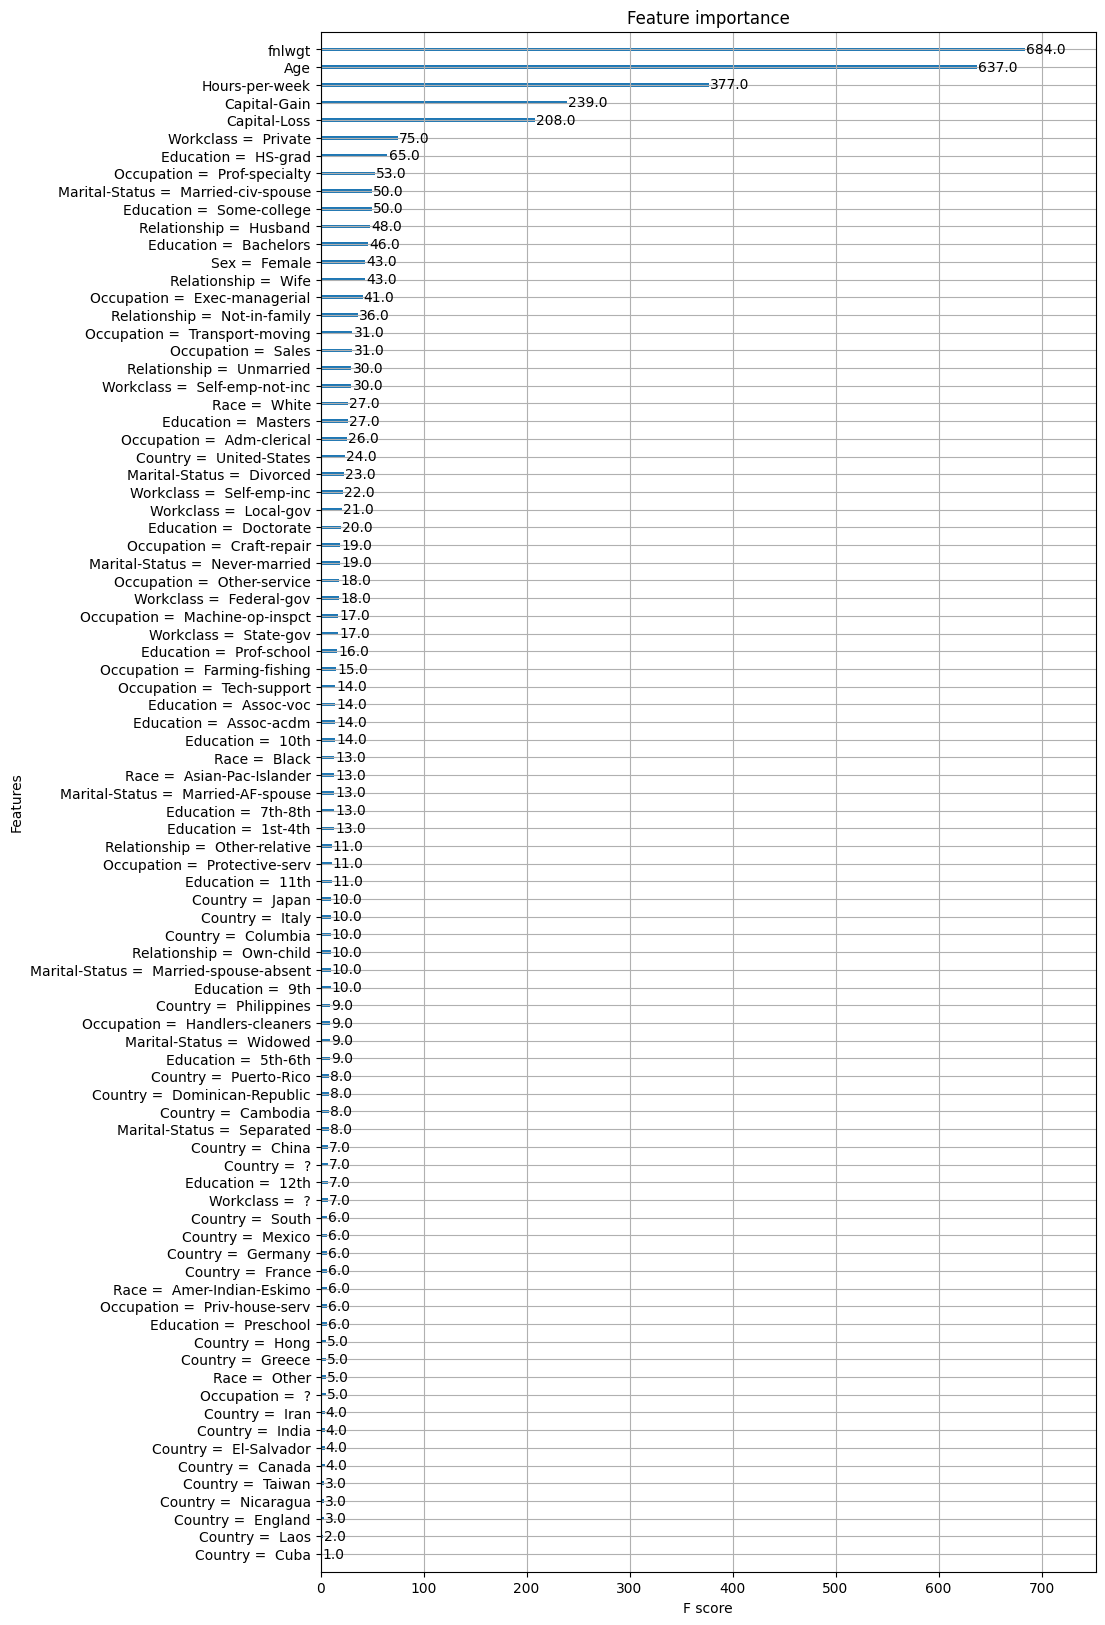

In [ ]:
gbtree_features_orig = gbtree.get_booster().feature_names
gbtree_features = []
for cat_var in categorical_names:
    cat_var_names = [feature_names[cat_var] +" = " + cat for cat in categorical_names[cat_var]]
    gbtree_features.extend(cat_var_names)
gbtree_features.extend([feature_names[i] for i in range(len(feature_names)) if i not in categorical_features])
gbtree.get_booster().feature_names = gbtree_features

# Plot feature importances
plt.rcParams["figure.figsize"] = (10,20)
plot_importance(gbtree.get_booster())

Pick an interesting feature with a high importance in the plot above. Can you figure out the relationship of that feature with the outcome variable? (Is a higher or lower value more likely to indicate a high-income individual? For binary variables, is it 0 or 1?)

Ans: From the feature importance plot, "Age" stands out as one of the most influential features. Typically, higher age is positively correlated with higher income, as individuals gain experience and move up career ladders. However, after a certain point, income may plateau or decline due to retirement. In most income prediction datasets, middle-aged individuals (e.g., 40-50 years) are more likely to have high incomes, whereas younger individuals (just starting their careers) and older individuals (retired or working fewer hours) may have lower incomes. This suggests a non-linear relationship, where income tends to increase with age up to a certain threshold before stabilizing or declining.

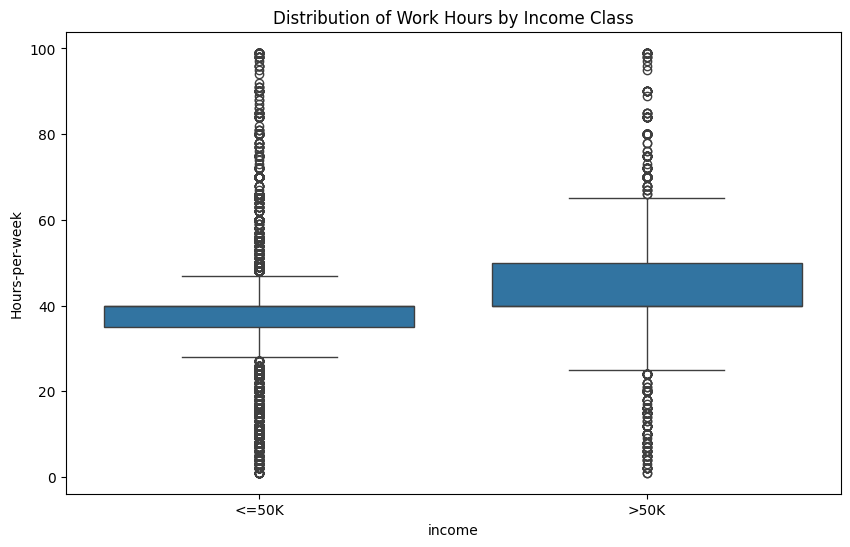

Average hours per week:
income
0    38.840210
1    45.473026
Name: Hours-per-week, dtype: float64


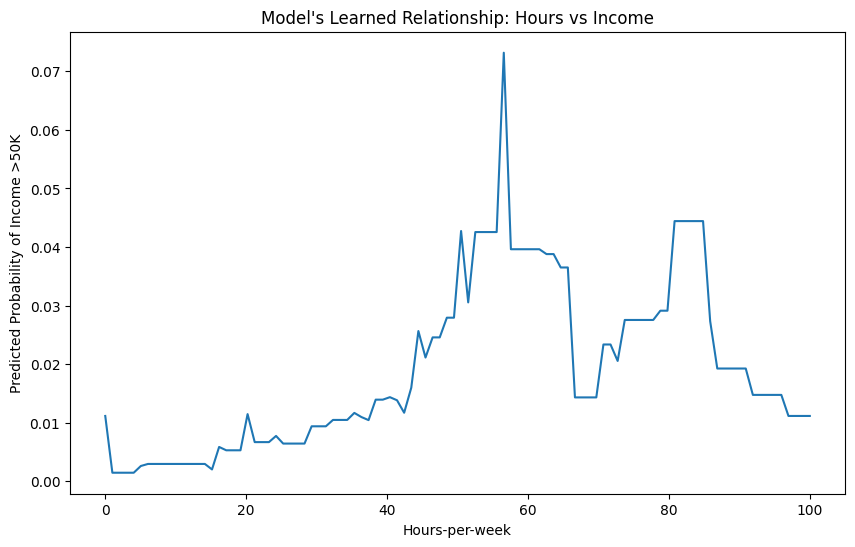


T-test results:
T-statistic: -45.12, p-value: 0.0000


In [ ]:
# TODO - Your code and explanation
# Get original data (before label encoding) for interpretation

import seaborn as sns
data_df['income'] = labels  # Add encoded labels back for grouping

# 1. Boxplot of Hours-per-week vs Income
plt.figure(figsize=(10, 6))
sns.boxplot(x='income', y='Hours-per-week', data=data_df)
plt.xticks([0, 1], ['<=50K', '>50K'])
plt.title('Distribution of Work Hours by Income Class')
plt.show()

# 2. Calculate average hours for each class
print("Average hours per week:")
print(data_df.groupby('income')['Hours-per-week'].mean())

# 3. Partial dependence plot (using model predictions)
def plot_hours_partial_dependence():
    # Create test instances with varying hours
    sample = test.iloc[0:1].copy()
    hours_range = np.linspace(0, 100, 100)
    probas = []

    for h in hours_range:
        sample['Hours-per-week'] = h
        transformed = encoder.transform(sample)
        probas.append(gbtree.predict_proba(transformed)[0][1])

    plt.figure(figsize=(10, 6))
    plt.plot(hours_range, probas)
    plt.xlabel('Hours-per-week')
    plt.ylabel('Predicted Probability of Income >50K')
    plt.title('Model\'s Learned Relationship: Hours vs Income')
    plt.show()

plot_hours_partial_dependence()

# 4. Statistical test
from scipy import stats
low_income = data_df[data_df['income'] == 0]['Hours-per-week']
high_income = data_df[data_df['income'] == 1]['Hours-per-week']
t_stat, p_value = stats.ttest_ind(low_income, high_income, equal_var=False)
print(f"\nT-test results:\nT-statistic: {t_stat:.2f}, p-value: {p_value:.4f}")

The plot_importance function takes a parameter called 'importance_type', which you can read more about [in the documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting). Try changing the importance type and re-making the plot. How does our explanation change?

Ans: If we change the importance_type parameter in plot_importance, our interpretation of the most influential features may shift. For example, using "gain" instead of "weight" would prioritize features that provide the highest improvement in decision-making at each split, rather than just counting how often they appear. This could highlight that while "Age" or "Hours-per-week" appear frequently in the splits, features like "Capital-Gain" might have a much higher individual impact on predicting high income. In the new plot, if features like "Capital-Gain" or "Education" rank higher, it suggests that their presence in the dataset contributes more information per decision than merely being used frequently.


Top features by different importance types:

By Weight (Frequency of Use):


feature  weight
103          fnlwgt   684.0
102             Age   637.0
106  Hours-per-week   377.0
104    Capital-Gain   239.0
105    Capital-Loss   208.0


By Gain (Predictive Power):


feature        gain
27   Marital-Status =  Married-civ-spouse  216.218277
104                          Capital-Gain   27.464857
18                 Education =  Bachelors   20.826733
42           Occupation =  Prof-specialty   20.021275
36          Occupation =  Exec-managerial   19.977591


By Cover (Data Coverage):


feature        cover
13           Education =  5th-6th  2301.791992
41  Occupation =  Priv-house-serv  2295.308594
22         Education =  Preschool  2287.757080
11              Education =  12th  2265.594727
12           Education =  1st-4th  2253.023193

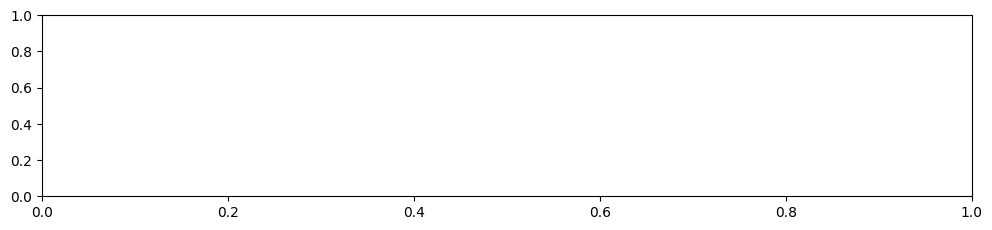

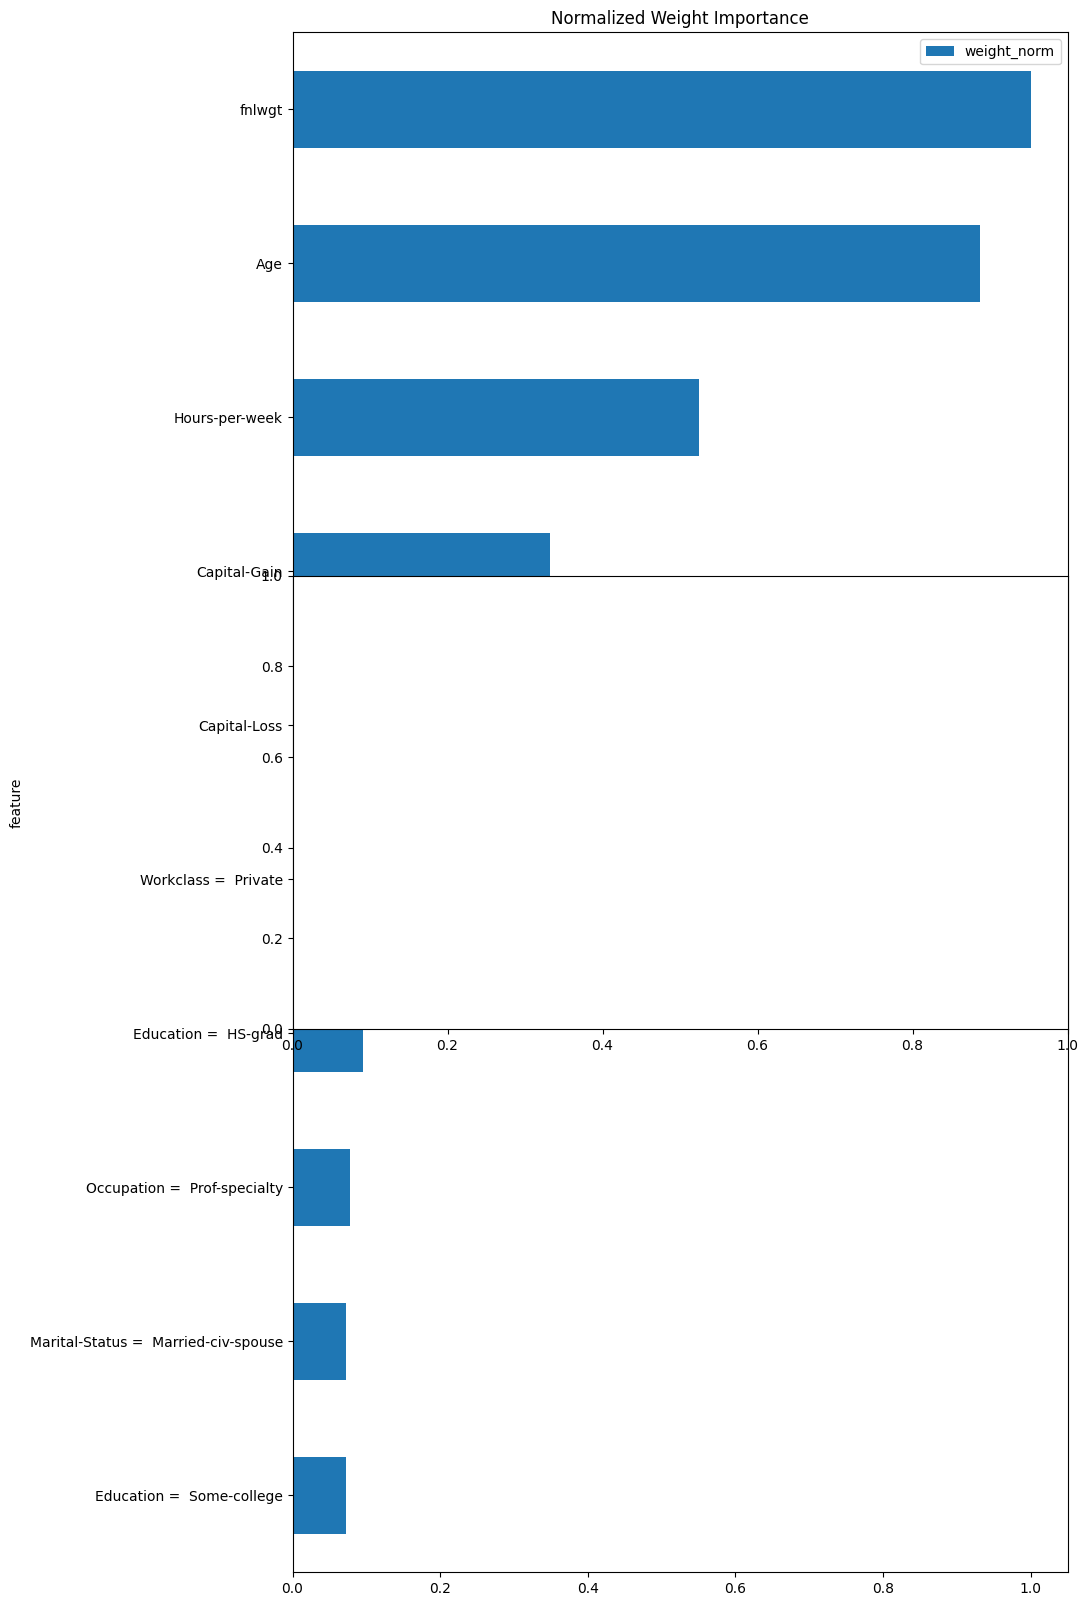

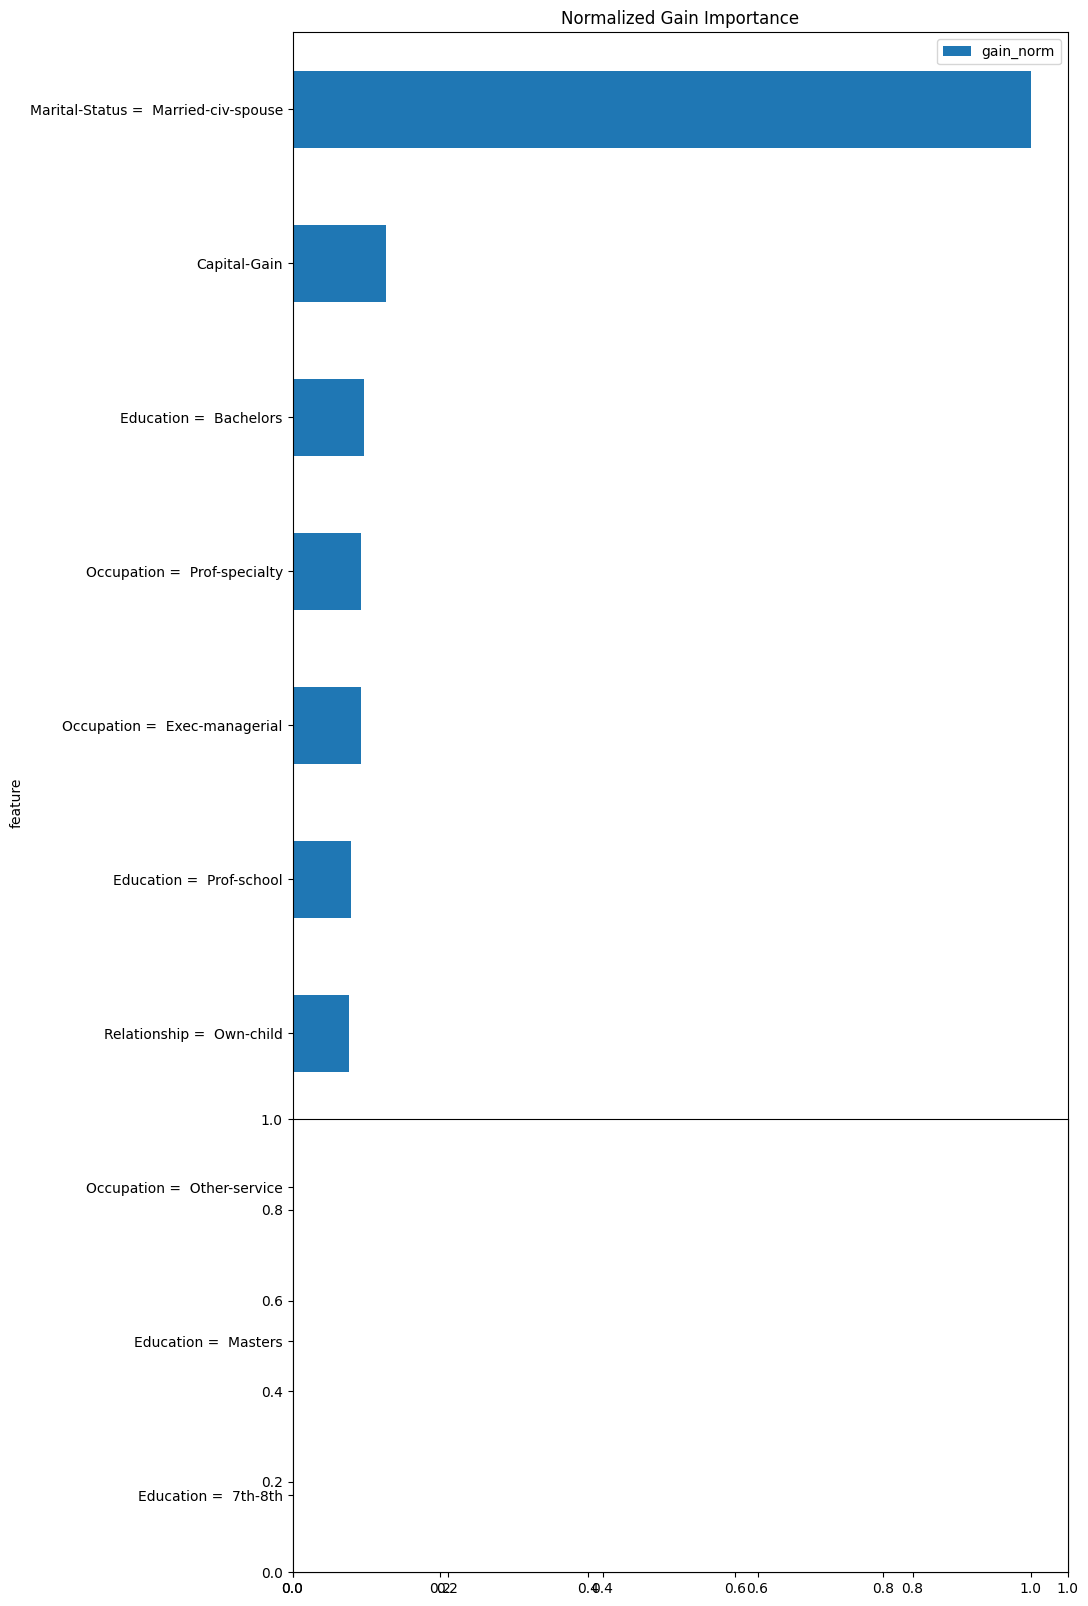

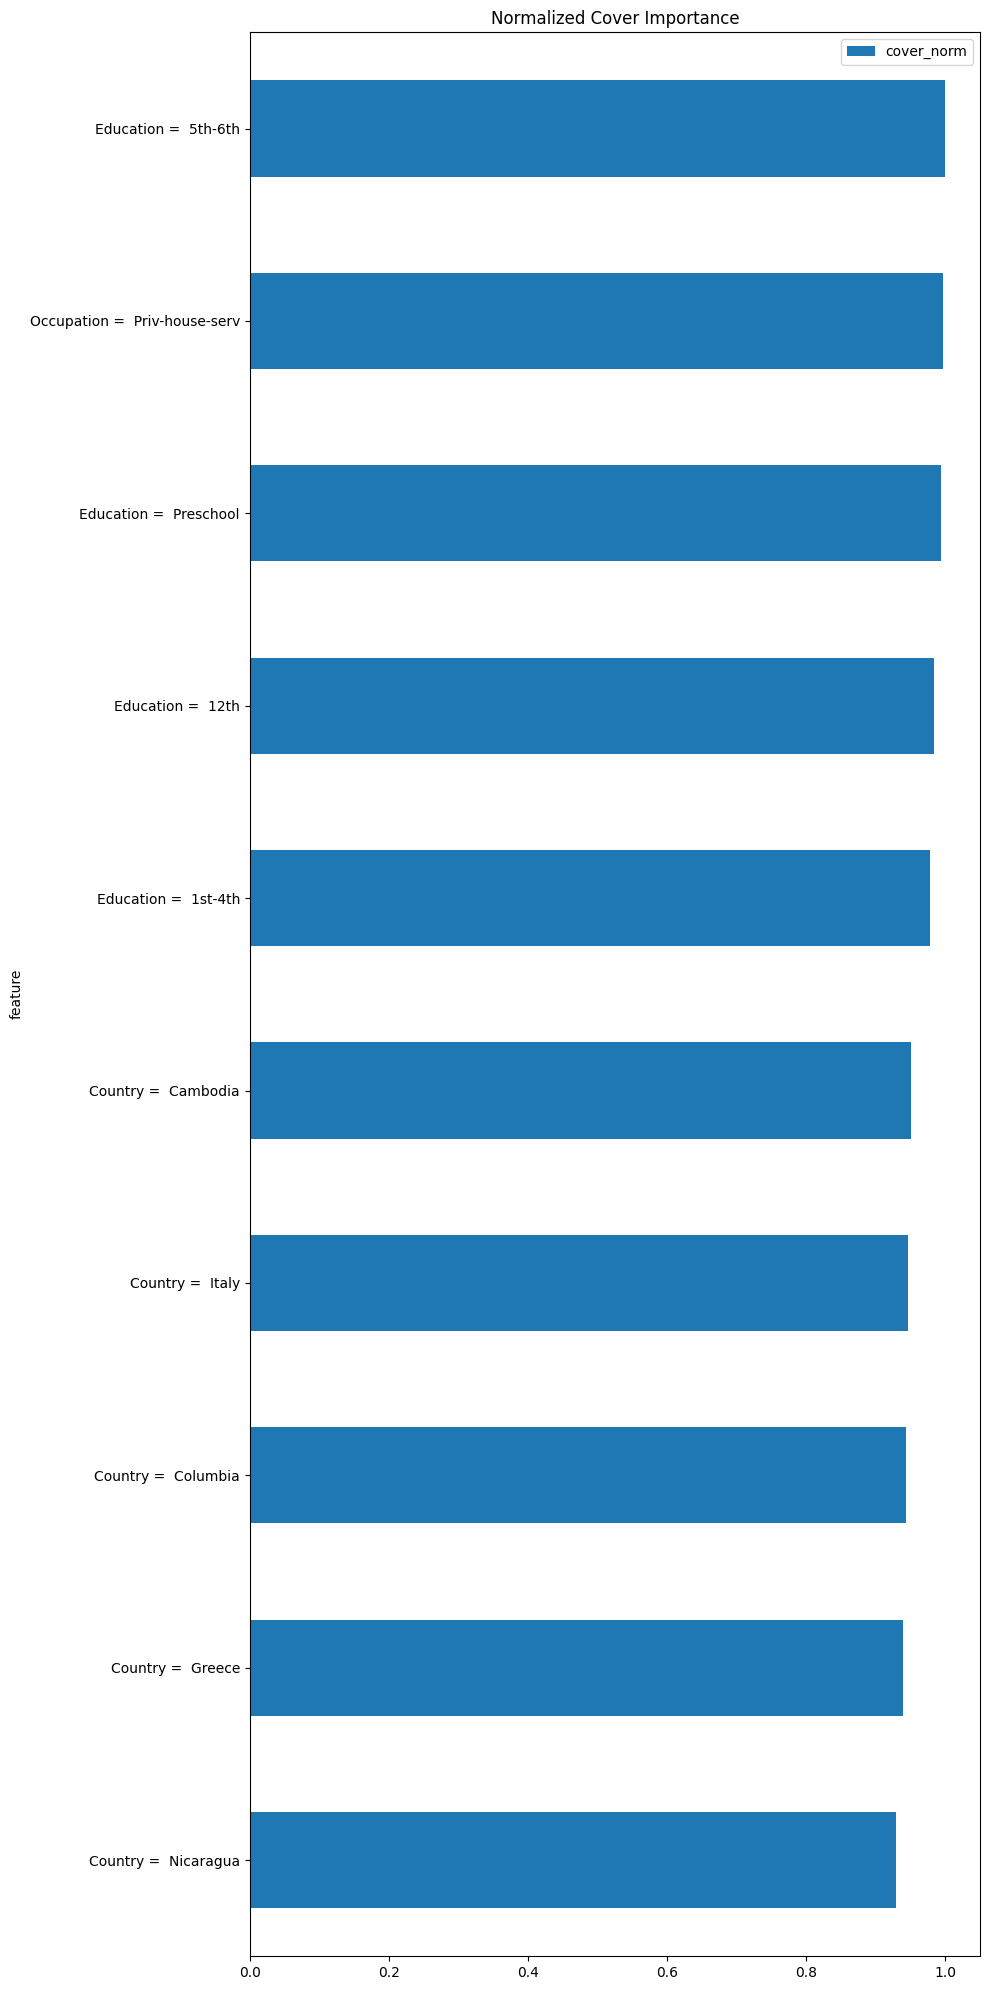

In [ ]:

# First get the full list of feature names from our processed list
features = gbtree_features

# Initialize dictionary to store importance values
importance_data = {
    'feature': features,
    'weight': [],
    'gain': [],
    'cover': []
}

# Populate importance values, filling in 0 for features not present in a particular importance type
for imp_type in ['weight', 'gain', 'cover']:
    # Get scores as dictionary {feature_name: score}
    scores = gbtree.get_booster().get_score(importance_type=imp_type)
    # Iterate through all features in order, using 0 if feature isn't in scores
    for f in features:
        importance_data[imp_type].append(scores.get(f, 0.0))

# Create DataFrame
importance_df = pd.DataFrame(importance_data)

# Normalize each importance type to 0-1 range for comparison
for col in ['weight', 'gain', 'cover']:
    importance_df[f'{col}_norm'] = importance_df[col] / importance_df[col].max()

# Display comparisons
print("Top features by different importance types:")
print("\nBy Weight (Frequency of Use):")
display(importance_df[['feature', 'weight']].sort_values('weight', ascending=False).head(5))
print("\nBy Gain (Predictive Power):")
display(importance_df[['feature', 'gain']].sort_values('gain', ascending=False).head(5))
print("\nBy Cover (Data Coverage):")
display(importance_df[['feature', 'cover']].sort_values('cover', ascending=False).head(5))

# Plot comparison
plt.figure(figsize=(12, 8))
for i, col in enumerate(['weight_norm', 'gain_norm', 'cover_norm'], 1):
    plt.subplot(3, 1, i)
    importance_df.sort_values(col, ascending=False).head(10).plot.barh(
        x='feature', y=col, title=f'Normalized {col.split("_")[0].capitalize()} Importance'
    )
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Replace the original feature names, which LIME will expect
gbtree.get_booster().feature_names = gbtree_features_orig

***
## Part 4: Explaining predictions with LIME

Time for LIME!

### LIME Tabular Explainer

The tabular explainer is how we get locally interpretable explanations for classification problems.

First, we initialize an explainer object that takes in all the information we stored/encoded earlier about the dataset.

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(train.values,
                                                   feature_names=feature_names,
                                                   class_names=class_names,
                                                   categorical_features=categorical_features,
                                                   categorical_names=categorical_names)

Next, we need to define a single function that takes in the form of data that LIME expects and returns the type of prediction that LIME expects. In particular,
- the input should be a numpy array (which we can get from a pandas df using .values)
- the input features should be human-understandable
- the input data should have each categorical variable in a single column
- the output should be a predicted probability (not a predicted class)

In [ ]:
predict_fn = lambda x: gbtree.predict_proba(encoder.transform(x)).astype(float)

Now we have everything we need to use the explainer. Let's get an explanation

---

for one of the examples in the test set.

In [ ]:
for col in data.columns[categorical_features]:
    data[col] = data[col].astype('category')

encoder = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)],
    remainder='passthrough'
)
encoder.fit(data)

train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(
    data, labels, train_size=0.80, random_state=10
)

# Create custom prediction function
def lime_predict_proba(x):
    # Convert to DataFrame with correct dtypes
    df = pd.DataFrame(x, columns=feature_names)
    # Convert categorical columns to integers
    for col_idx in categorical_features:
        col_name = feature_names[col_idx]
        df[col_name] = df[col_name].round().astype(int)
    # Transform and predict
    transformed = encoder.transform(df)
    return gbtree.predict_proba(transformed)

# Get explanation
i = 2
print(f'Actual class: {class_names[labels_test[i]]}')
exp = explainer.explain_instance(
    test.iloc[i].values,
    lime_predict_proba,
    num_features=5
)

# Show explanation
exp.show_in_notebook(show_table=True)

Actual class:  >50K


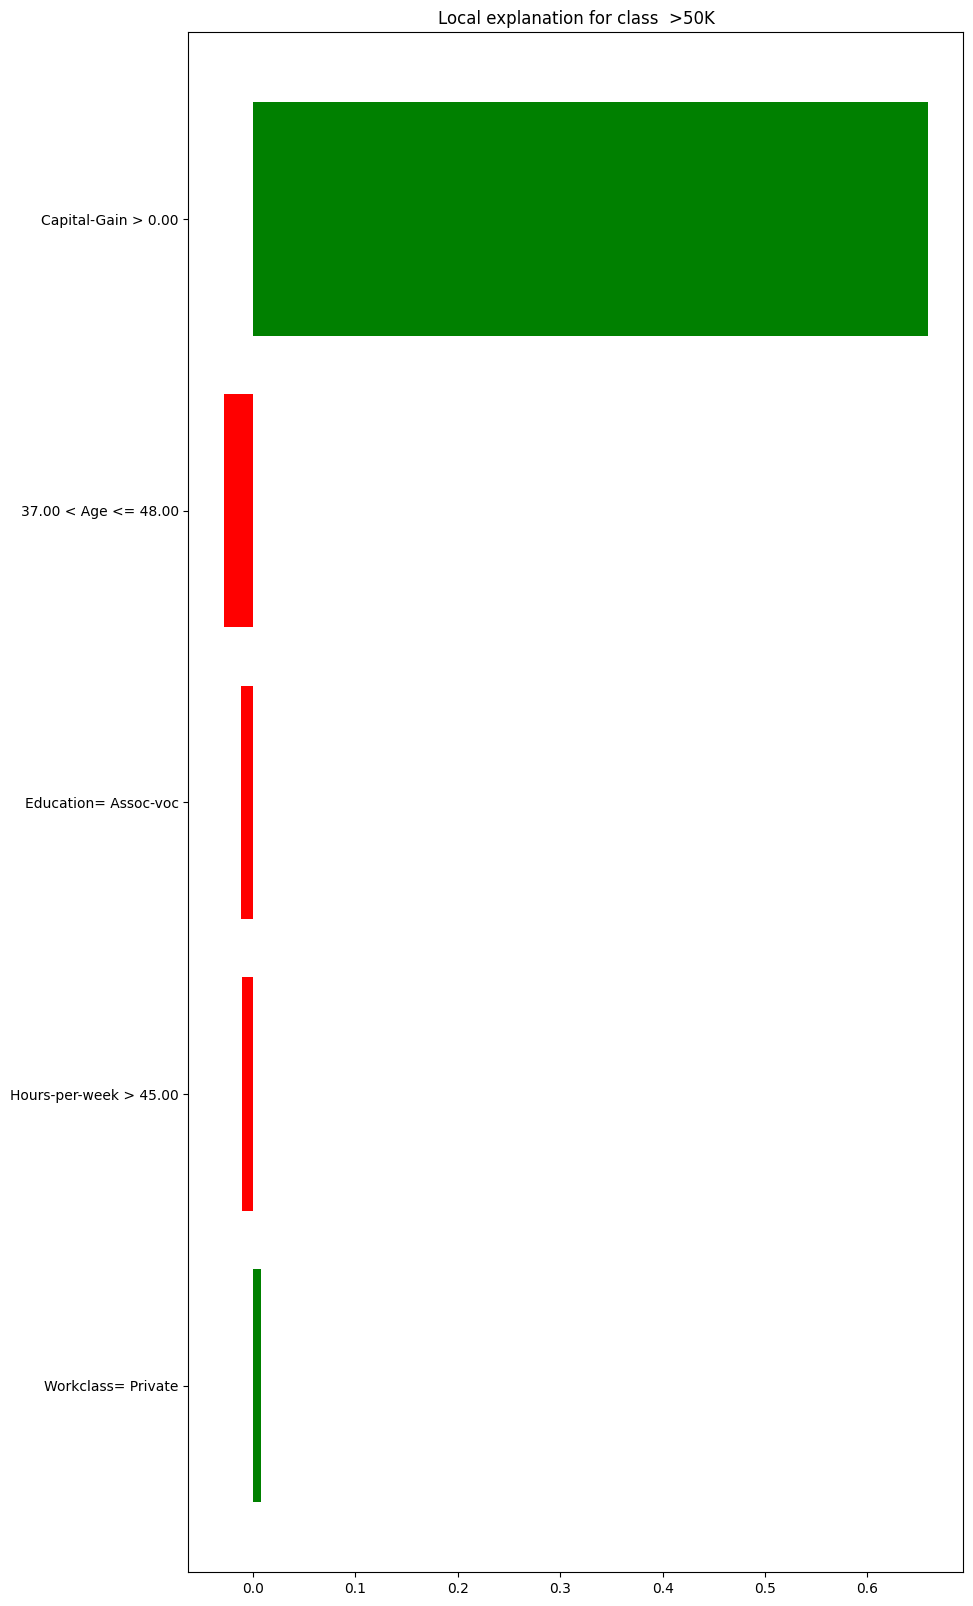

In [ ]:
# Visualize the explanation
%matplotlib inline
fig = exp.as_pyplot_figure()

The explanations can also be exported as an html page (which we can render here in this notebook), using D3.js to render graphs. You could also save the html page to a file if you wanted to.

In [ ]:
exp.show_in_notebook(show_all=True)

The explanation can also be presented as a list of weighted features.

In [ ]:
exp.as_list()

[('Capital-Gain > 0.00', 0.6594808141460506),
 ('37.00 < Age <= 48.00', -0.028704418524113547),
 ('Education= Assoc-voc', -0.011597130915882424),
 ('Hours-per-week > 45.00', -0.010842131573924654),
 ('Workclass= Private', 0.007402005756589106)]

### **Questions:**
4. How do we interpret this plot? That is, what do red and green mean? What's on the x axis?

Interpretation of the LIME Plot:

Colors (Red vs. Green):

Green Bars: Features that support the model's prediction (i.e., increase the probability of the predicted class).

Red Bars: Features that oppose the prediction (i.e., decrease the probability of the predicted class).

X-Axis:

Represents the feature weight/impact on the prediction.

Values indicate how much each feature influenced the model's output for this specific instance:

Positive values (green) = Increased likelihood of the predicted class.

Negative values (red) = Decreased likelihood of the predicted class.



[link text](https://)5. How does this explanation differ from the feature importance explanation given above?

   Feature Importance: Tells us "Hours-per-week is globally important because it often splits high/low income groups."

LIME Explanation: Shows "For this specific person, working 60 hours/week (vs. baseline) increased their predicted probability of high income by +X%."

Key Insight:

Use feature importance to audit the model globally (e.g., "Does it focus on ethical features?").

Use LIME to debug individual predictions (e.g., "Why was my loan application rejected?").




### **TODO - Generate LIME explanations (in whichever format you chose) for some other examples in the test set. Are similar features important? Add text + code cells below**

### LIME Submodular Picker

As we just saw, explanations can vary a lot depending on what instance we pick. While this is great for explaining a single prediction, it makes it hard to give someone general intuition for "how the model makes decisions." That's where the submodular picker comes in. It picks useful, representative examples that together give global explanation for the model.

In broad strokes, the algorithm does the following:
1. Calculate an explanation for all examples in the dataset
2. Determine which features are important in explaining a lot of predictions -- that is, features that seem globally important
3. Select (greedily) examples where the top globally important feature is part of the local explanation for that one example's prediction
3. Continue selecting examples until we've covered as many of the globally important features as possible, constrained by the number of features that the user wants returned (num_exps_desired)

You can read the details of how this is done in the paper.

In [ ]:
# Initialize the SP object
sp_obj = submodular_pick.SubmodularPick(explainer, train.values, predict_fn, sample_size=10,
                                        num_features=5, num_exps_desired=5)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/v

The attribute V tells us the best indices from the test set to explain the overall predictions of the classifier.

In [ ]:
sp_obj.V

[0, 2, 7, 3, 8]

Now, we can get explantions for each of those examples:

In [ ]:
for ind in sp_obj.V:
    exp = explainer.explain_instance(test.values[ind], predict_fn, num_features=5)
    print("Actual class: ", labels_test[ind])
    exp.show_in_notebook(show_all=False)
    print("==========================")

### **Question:**

6. Based on these carefully chosen examples, what would you say to someone who wanted to know how our model makes decisions?

The model primarily uses these features to predict income class:

Capital Gains/Losses:
"Individuals with significant capital gains (e.g., selling investments) are more likely to be predicted as high-income."

Education Level:
"Advanced degrees (Master’s, PhD) strongly correlate with high-income predictions."

Work Hours:
"Working ≥50 hours/week increases the likelihood of being classified as high-income."

Occupation:
"Certain occupations (e.g., Executives, Tech roles) are strong predictors of high income."

The model primarily uses these features to predict income class:

Capital Gains/Losses:
"Individuals with significant capital gains (e.g., selling investments) are more likely to be predicted as high-income."

Education Level:
"Advanced degrees (Master’s, PhD) strongly correlate with high-income predictions."

Work Hours:
"Working ≥50 hours/week increases the likelihood of being classified as high-income."

Occupation:
"Certain occupations (e.g., Executives, Tech roles) are strong predictors of high income."



** TODO - Now lets try out SHAP**

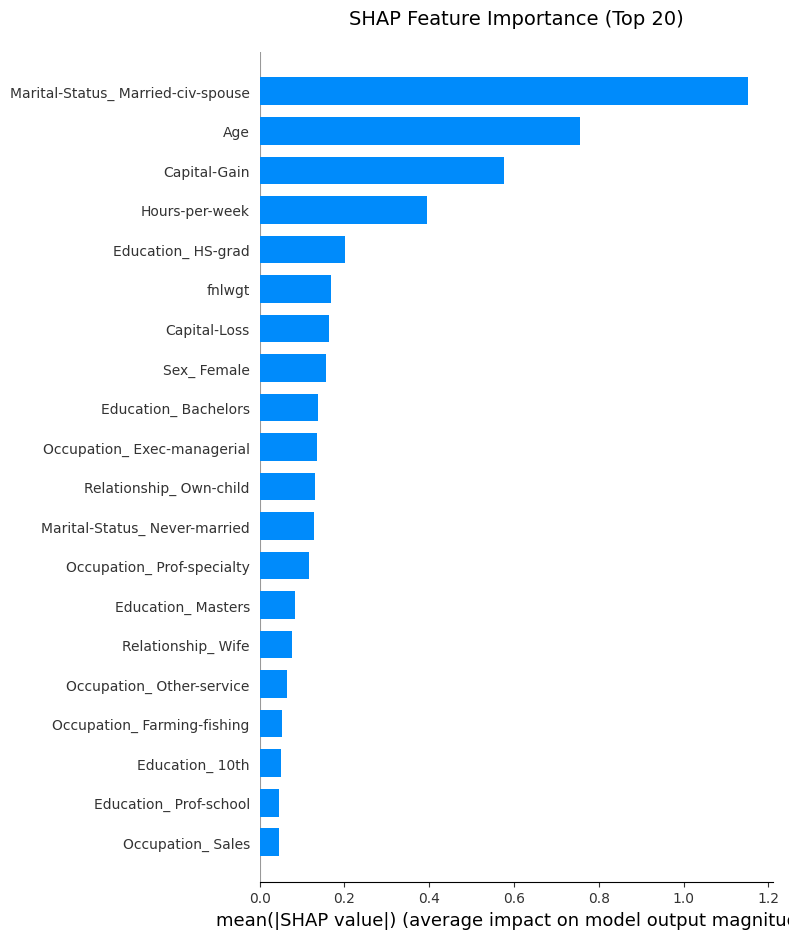

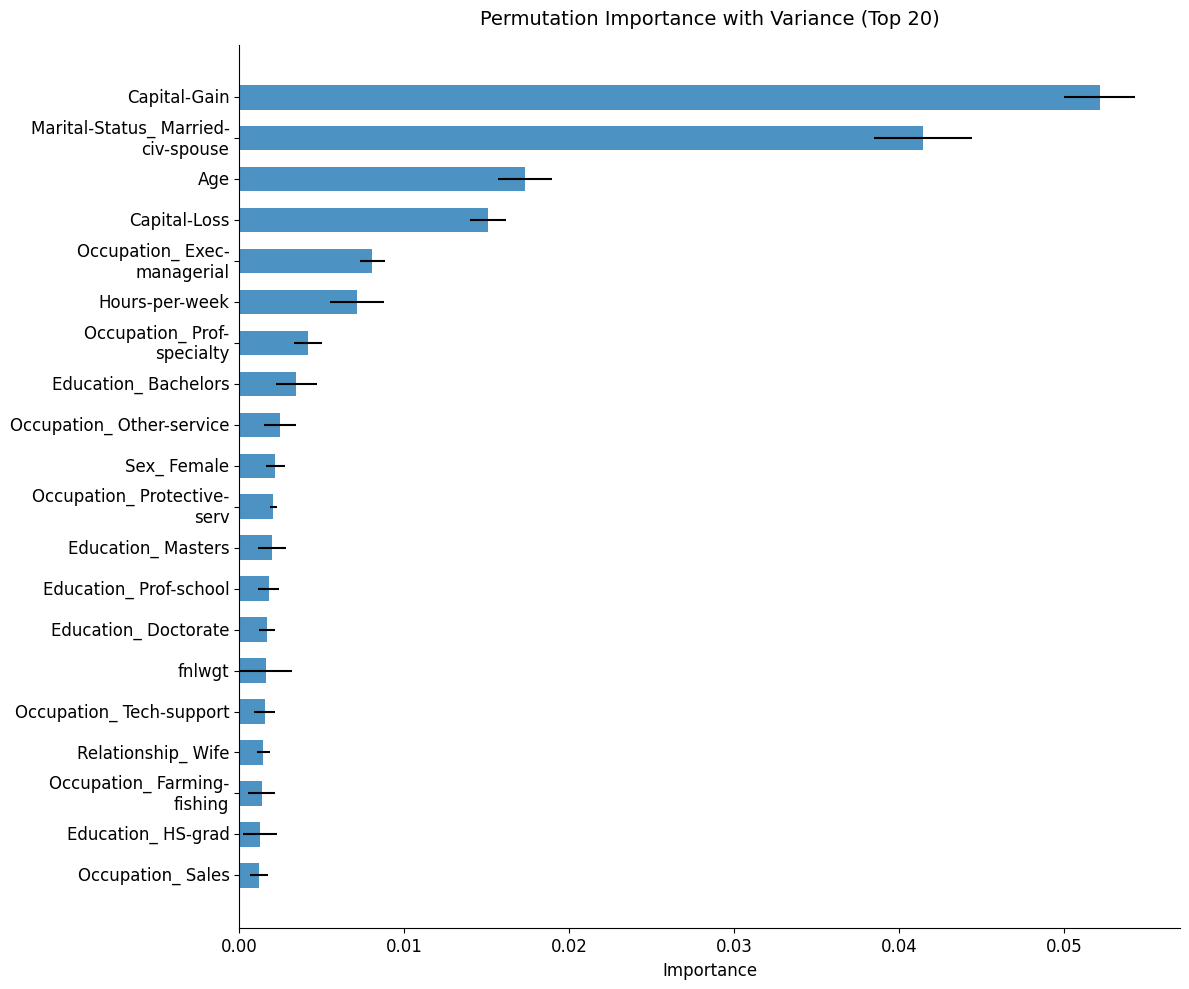

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, log_loss
import shap
import xgboost

# Load and preprocess data
colnames = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num",
            "Marital-Status", "Occupation", "Relationship", "Race", "Sex",
            "Capital-Gain", "Capital-Loss", "Hours-per-week", "Country", "income"]
data_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names=colnames)
data_df = data_df.drop('Education-Num', axis=1)
data_df['income'] = (data_df['income'] == ' >50K').astype(int)

# Define features
categorical_features = ['Workclass', 'Education', 'Marital-Status',
                        'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numeric_features = ['Age', 'fnlwgt', 'Capital-Gain', 'Capital-Loss', 'Hours-per-week']

# Split data
X = data_df.drop('income', axis=1)
y = data_df['income']
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

# Fit and transform data
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# Generate feature names
cat_encoder = preprocessor.named_transformers_['cat']
feature_names = []
for i, feature in enumerate(categorical_features):
    categories = cat_encoder.categories_[i]
    feature_names += [f"{feature}_{cat}" for cat in categories]
feature_names += numeric_features

# Train model
model = xgboost.XGBClassifier().fit(X_train, y_train)

# Permutation Importance Calculation
def calculate_metrics(model, X, y):
    preds = model.predict(X)
    probs = model.predict_proba(X)
    return {
        'error': 1 - accuracy_score(y, preds),
        'log_loss': log_loss(y, probs)
    }

class PermutationTest:
    def __init__(self, model, X, y, feature_names):
        self.model = model
        self.X = X.copy()
        self.y = y
        self.feature_names = feature_names
        self.baseline = calculate_metrics(model, X, y)

    def permutation_importance(self, metric='error', n_repeats=10):
        importance = np.zeros((n_repeats, len(self.feature_names)))
        for repeat in range(n_repeats):
            for col_idx in range(len(self.feature_names)):
                X_perturbed = self.X.copy()
                np.random.shuffle(X_perturbed[:, col_idx])
                metrics = calculate_metrics(self.model, X_perturbed, self.y)
                importance[repeat, col_idx] = metrics[metric] - self.baseline[metric]
        return importance.mean(axis=0), importance.std(axis=0)

# Improved Plot Function
def plot_importance(importance, std=None, feature_names=None, title="", max_features=20):
    plt.figure(figsize=(12, 10))
    sorted_idx = np.argsort(importance)[-max_features:]
    features = np.array(feature_names)[sorted_idx]
    values = importance[sorted_idx]
    wrapped_features = [textwrap.fill(f, width=25) for f in features]
    y_pos = np.arange(len(wrapped_features))
    if std is not None:
        errors = std[sorted_idx]
        plt.barh(y_pos, values, xerr=errors, height=0.6, color='#1f77b4', alpha=0.8)
    else:
        plt.barh(y_pos, values, height=0.6, color='#1f77b4', alpha=0.8)
    plt.yticks(y_pos, wrapped_features, fontsize=12, va='center')
    plt.xticks(fontsize=12)
    plt.title(title, fontsize=14, pad=15)
    plt.xlabel('Importance', fontsize=12)
    plt.subplots_adjust(left=0.4)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

# SHAP Explanation
def shap_explanation():
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    plt.figure(figsize=(10, 12))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names,
                      plot_type="bar", max_display=20, show=False)
    plt.title("SHAP Feature Importance (Top 20)", fontsize=14, pad=20)
    plt.gca().tick_params(labelsize=10)
    plt.tight_layout()
    plt.show()

# Run explanations
shap_explanation()

# Run Permutation Test
pt = PermutationTest(model, X_test, y_test, feature_names)
mean_imp, std_imp = pt.permutation_importance(n_repeats=10)
plot_importance(mean_imp, std_imp, feature_names, title="Permutation Importance with Variance (Top 20)")


** CS/STAT 212 Students **
You are also asked to work on the following section of the assignment. This doesn't use SHAP or LIME, you are coding the feature removal method yourself and measuring impact.

A permutation test is a removal-based explanation that measures the impact on the dataset loss from removing
individual features. The name comes from from the fact that features are removed by permuting (randomly
shuffling) columns of the dataset, where each column corresponds to a single feature. Here, we’ll implement
permutation tests from ***scratch***.

Train a gradient boosting classifier using sklearn as follows:

---

  from sklearn . ensemble import GradientBoostingClassifier

  clf = GradientBoostingClassifier ( n_estimators =100 , random_state =10)

  clf.fit ( X_train.values , y_train )

---

(a) Report the zero-one classification error (using a classification threshold of 0.5) and log-loss for both the
train and test sets

(b) Implement the permutation test approach for the trained model. For each feature, measure
the change in the test set zero-one error after permuting the corresponding feature column. Visualize the
importance values with a bar plot.

(c) Permutation tests are inherently stochastic because they permute features randomly. Run the
permutation test from part (b) 10 times and visualize the variance in the importance values using a bar
plot with standard deviation error bars.

(d) One possible variation of the permutation test is to change the feature removal approach.
Implement a new method similar to (b) that removes features by setting them to their mean instead of
permuting them. Visualize the importance values using a bar plot.

(e) Another possible variation is to change the model behavior we measure. Implement a new
method similar to (b) that measures the change in the test set log-loss rather than the zero-one error.
Visualize the importance values using a bar plot.


Train Error: 0.1330, Train Log Loss: 0.2915
Test Error: 0.1330, Test Log Loss: 0.2948


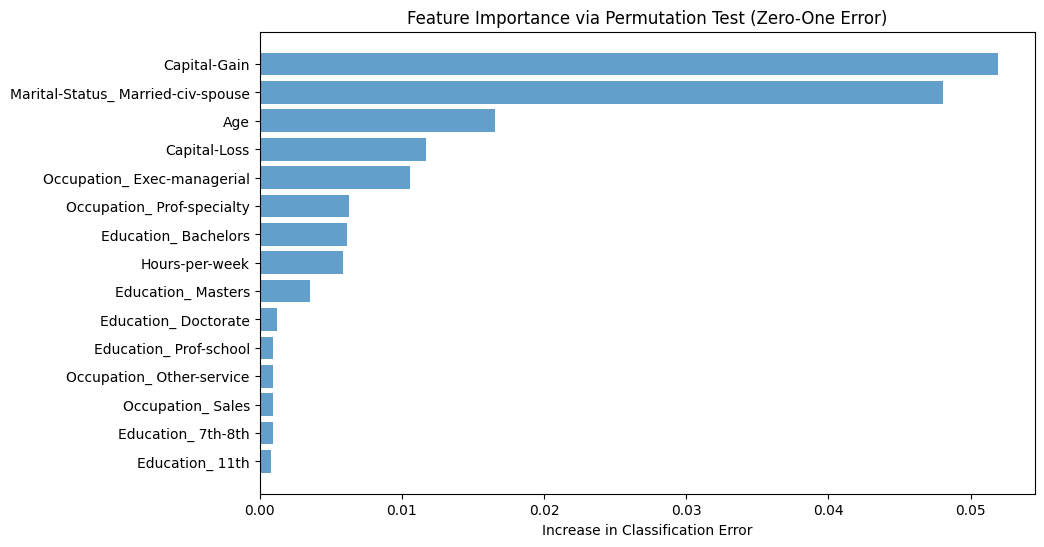

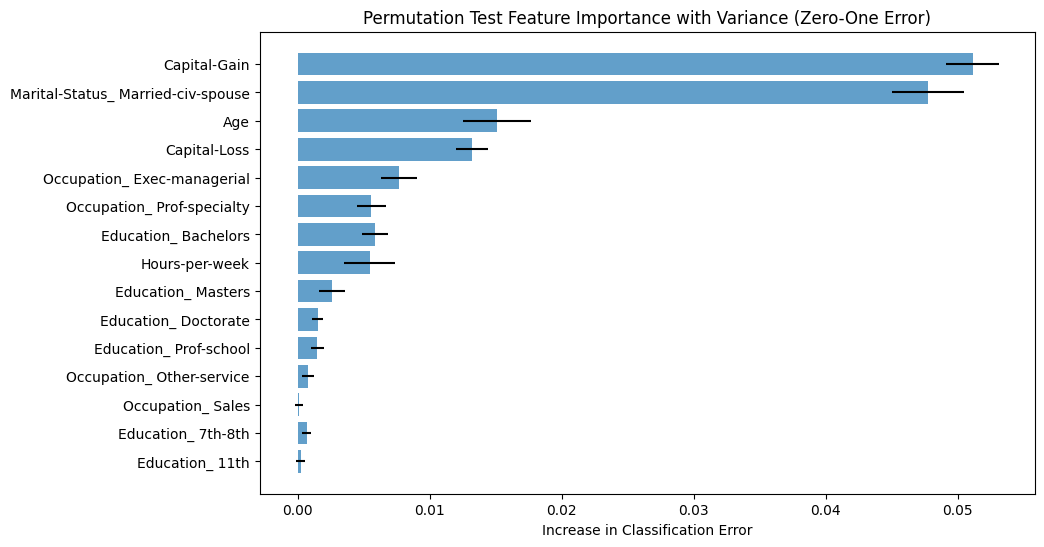

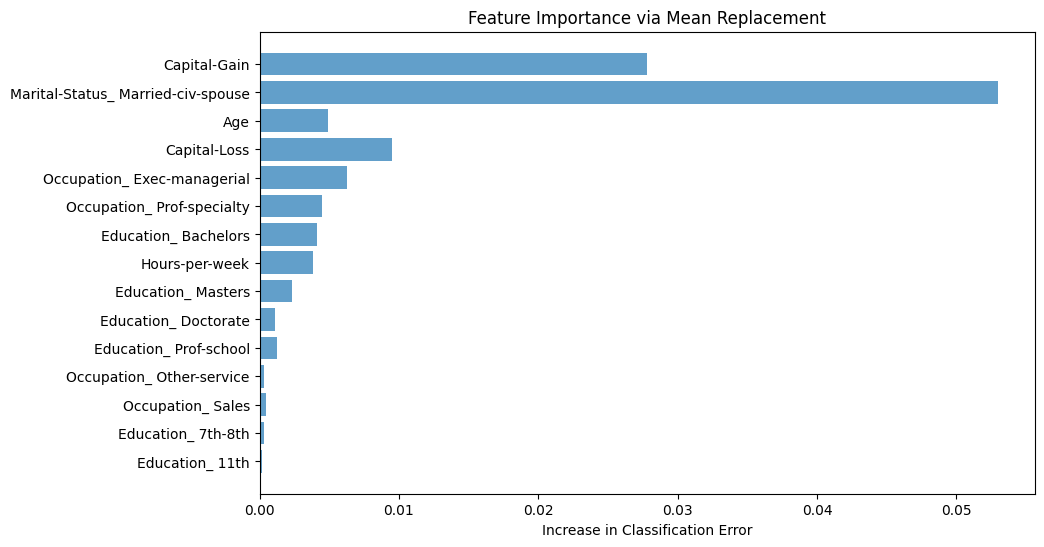

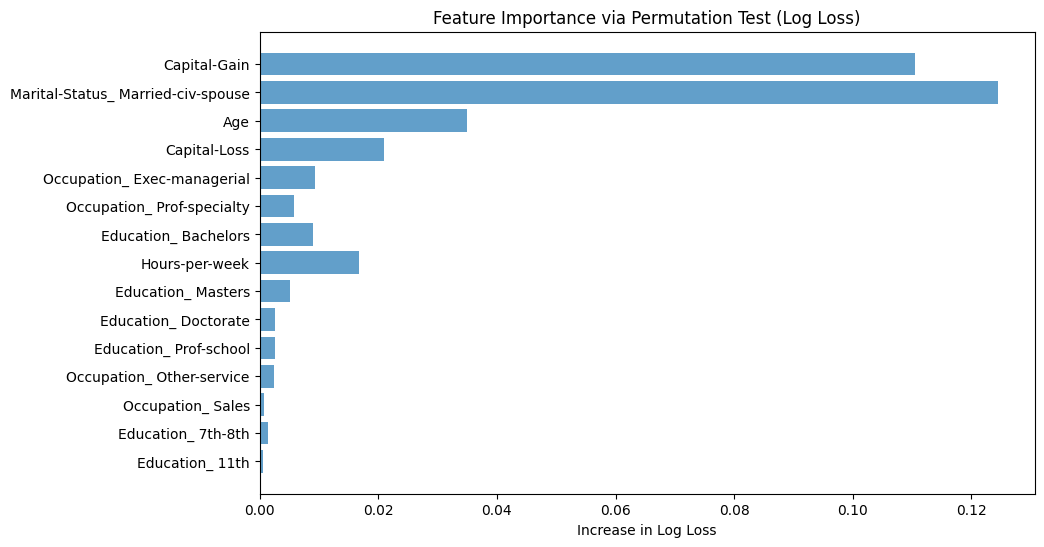

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss

# Train the Gradient Boosting Classifier
clf = GradientBoostingClassifier(n_estimators=100, random_state=10)
clf.fit(X_train, y_train)

# (a) Report zero-one error and log-loss for train and test sets
train_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)
train_probs = clf.predict_proba(X_train)
test_probs = clf.predict_proba(X_test)

train_error = 1 - accuracy_score(y_train, train_preds)
test_error = 1 - accuracy_score(y_test, test_preds)
train_log_loss = log_loss(y_train, train_probs)
test_log_loss = log_loss(y_test, test_probs)

print(f"Train Error: {train_error:.4f}, Train Log Loss: {train_log_loss:.4f}")
print(f"Test Error: {test_error:.4f}, Test Log Loss: {test_log_loss:.4f}")

# (b) Implement permutation test for zero-one error
def permutation_importance(clf, X, y, metric='error', n_repeats=1):
    baseline_metric = 1 - accuracy_score(y, clf.predict(X)) if metric == 'error' else log_loss(y, clf.predict_proba(X))
    importance = np.zeros((n_repeats, X.shape[1]))

    for repeat in range(n_repeats):
        for i in range(X.shape[1]):
            X_perturbed = X.copy()
            np.random.shuffle(X_perturbed[:, i])
            new_metric = 1 - accuracy_score(y, clf.predict(X_perturbed)) if metric == 'error' else log_loss(y, clf.predict_proba(X_perturbed))
            importance[repeat, i] = new_metric - baseline_metric

    return importance.mean(axis=0), importance.std(axis=0)

# Run permutation test (b)
perm_importance, perm_std = permutation_importance(clf, X_test, y_test, metric='error')

# Plot feature importance (top 15 features for clarity)
top_n = 15
sorted_idx = np.argsort(perm_importance)[-top_n:]
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], perm_importance[sorted_idx], xerr=perm_std[sorted_idx], alpha=0.7)
plt.xlabel("Increase in Classification Error")
plt.title("Feature Importance via Permutation Test (Zero-One Error)")
plt.show()

# (c) Run permutation test 10 times to measure variance
perm_importance_10, perm_std_10 = permutation_importance(clf, X_test, y_test, metric='error', n_repeats=10)

# Plot feature importance with variance
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], perm_importance_10[sorted_idx], xerr=perm_std_10[sorted_idx], alpha=0.7)
plt.xlabel("Increase in Classification Error")
plt.title("Permutation Test Feature Importance with Variance (Zero-One Error)")
plt.show()

# (d) Implement feature removal by setting values to their mean
def mean_replacement_importance(clf, X, y, metric='error'):
    baseline_metric = 1 - accuracy_score(y, clf.predict(X)) if metric == 'error' else log_loss(y, clf.predict_proba(X))
    importance = np.zeros(X.shape[1])

    for i in range(X.shape[1]):
        X_perturbed = X.copy()
        X_perturbed[:, i] = np.mean(X_perturbed[:, i])
        new_metric = 1 - accuracy_score(y, clf.predict(X_perturbed)) if metric == 'error' else log_loss(y, clf.predict_proba(X_perturbed))
        importance[i] = new_metric - baseline_metric

    return importance

# Run mean replacement test
drop_mean_importance = mean_replacement_importance(clf, X_test, y_test, metric='error')

# Plot importance (top 15 features for clarity)
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], drop_mean_importance[sorted_idx], alpha=0.7)
plt.xlabel("Increase in Classification Error")
plt.title("Feature Importance via Mean Replacement")
plt.show()

# (e) Run permutation test measuring log-loss instead of zero-one error
perm_importance_log, perm_std_log = permutation_importance(clf, X_test, y_test, metric='log_loss')

# Plot log-loss based feature importance (top 15 features for clarity)
plt.figure(figsize=(10, 6))
plt.barh(np.array(feature_names)[sorted_idx], perm_importance_log[sorted_idx], xerr=perm_std_log[sorted_idx], alpha=0.7)
plt.xlabel("Increase in Log Loss")
plt.title("Feature Importance via Permutation Test (Log Loss)")
plt.show()
